# 异常检测
Weina Ma - January 30, 2018

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as plt
import numpy as np
import missingno as msno
%matplotlib inline
pd.set_option('display.max_rows',None)
pd.options.display.float_format = '{:.0f}'.format

df=pd.read_csv('/vagrant/gong_hang/callcenter/data/20180105_result.csv',encoding='gbk')
#df.drop(["CALLING_NUM"], axis=1, inplace=True)
df.head()

,CALLING_NUM,MEAN_INTERVAL_CALL,SD_INTERVAL_CALL,NUM_CALL,MEAN_DURATION,MOST_DURATION,MOST_DURATION_NUM,SD_DURATION,TOTAL_DURATION,TRK_NUM
0,2195511,2,0,3,66,66,1,33,192,1
1,2195516,24,18,3,252,216,1,99,870,2
2,2410016,1440,0,1,6,6,1,0,6,1
3,4699417,3,0,2,90,42,1,68,180,1
4,5006013,5,0,2,63,42,1,30,126,1


In [2]:
print df.shape
df.describe()

(316827, 10)


,CALLING_NUM,MEAN_INTERVAL_CALL,SD_INTERVAL_CALL,NUM_CALL,MEAN_DURATION,MOST_DURATION,MOST_DURATION_NUM,SD_DURATION,TOTAL_DURATION,TRK_NUM
count,316827,316827,316827,316827,316827,316827,316827,316827,316827,316827
mean,108450105917,999,5,2,140,143,1,25,213,1
std,4486480603148,649,31,1,126,136,0,61,233,0
min,2195511,0,0,1,0,0,1,0,0,1
25%,13766566220,40,0,1,60,54,1,0,72,1
50%,15333446615,1440,0,1,96,90,1,0,144,1
75%,18116004669,1440,0,2,192,198,1,15,282,1
max,930037165318000,1440,688,117,5703,5556,104,3750,13128,13


## 1. 基于统计和数据分布的检测算法
如果某个值距离分布的均值超过一定范围，那么这个值就可以被简单的标记为一个异常点（outlier）
* 电话拨打次数（利用原始分布）
* 平均时长（利用函数变换后分布）

In [3]:
num_call_outlier = 5
df_1 = df[df['NUM_CALL'] > num_call_outlier]
df_1.shape

(4813, 10)

### 原始分布

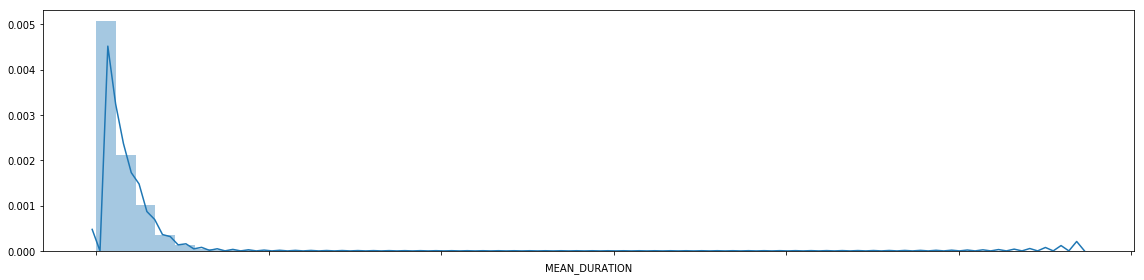

In [4]:
plt.pyplot.figure(figsize=(16,4))
ax = sns.distplot(df['MEAN_DURATION']);
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.pyplot.tight_layout()
plt.pyplot.show()

### 函数变换后分布

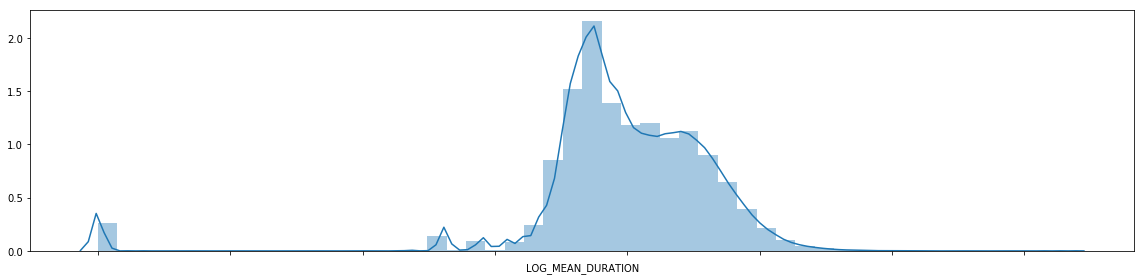

In [5]:
df['LOG_MEAN_DURATION'] = np.power(df['MEAN_DURATION'], 0.15)
#df['LOG_MEAN_DURATION'] = np.log(1+df['MEAN_DURATION'])

plt.pyplot.figure(figsize=(16,4))
ax = sns.distplot(df['LOG_MEAN_DURATION']);
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.pyplot.tight_layout()
plt.pyplot.show()

In [7]:
print df['LOG_MEAN_DURATION'].mean()
print df['LOG_MEAN_DURATION'].std()

1.98453908343
0.367695082274


In [8]:
df_1 = df[(df['LOG_MEAN_DURATION'] > 3.09) | (df['LOG_MEAN_DURATION'] < 0.89) ]
df_1.shape

(6068, 11)

## 2. 基于距离/密度发现异常点
* 局部异常因子算法
https://github.com/damjankuznar/pylof

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from lof import LOF
from lof import outliers

data=pd.read_csv('/vagrant/gong_hang/callcenter/data/20180105_scale.csv',encoding='gbk')
XXX = data[['NUM_CALL', 'MEAN_DURATION']]
XX = XXX.head(200)
X=np.array(np.rec.fromrecords(XX.values))

#lof = LOF(X)
lof = outliers(5, X)
for outlier in lof:
    print outlier["lof"],outlier["instance"]

3.60726677482 (2.5255547062686707, -0.8270822932013109)
3.22558527979 (2.5255547062686707, 1.2678862773419233)
2.10602889174 (1.0499358415377105, -0.017662618218697787)
2.02840130518 (1.0499358415377105, 0.886982900879517)
1.99505022347 (1.7877452739031907, 0.6013053685327123)
1.99232689946 (1.0499358415377105, 0.8393699788217163)
1.94954750966 (1.0499358415377105, 1.7440154979199307)
1.92928750602 (-0.4256830231932506, 6.5529206257578085)
1.65413182832 (-0.4256830231932506, 3.4580806920007587)
1.6248639801 (0.31212640917222995, 3.267629003769556)
1.54091743405 (1.0499358415377105, -0.2557272285077017)
1.28706004366 (-0.4256830231932506, 3.934209912578767)
1.23158237754 (-0.4256830231932506, 5.3625975743127885)
1.19616487475 (1.0499358415377105, -0.398565994681104)
1.17554694533 (-0.4256830231932506, 3.838984068463165)
1.17554694533 (-0.4256830231932506, 3.838984068463165)
1.09481433983 (-0.4256830231932506, 5.1245329640237856)
1.08483770556 (0.31212640917222995, 2.767693322162648)
1.0

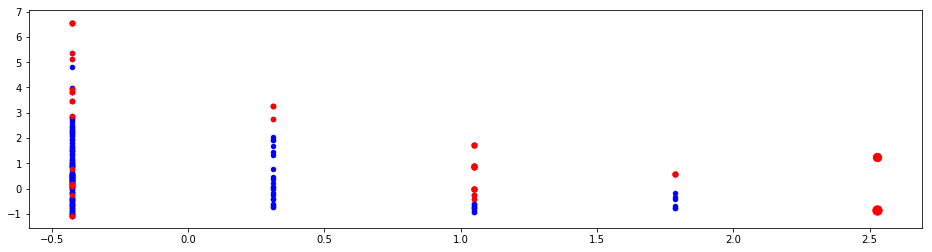

In [10]:
from matplotlib import pyplot as p

x,y = zip(*X)
p.figure(figsize=(16,4))
p.scatter(x,y, 20, color="#0000FF")

for outlier in lof:
    value = outlier["lof"]
    instance = outlier["instance"]
    color = "#FF0000" if value > 1 else "#00FF00"
    p.scatter(instance[0], instance[1], color=color, s=(value-1)**2*10+20)

p.show()

## 3. 基于划分思想
* 孤立层林

假设我们用一个随机超平面来切割（split）数据空间（data space）, 切一次可以生成两个子空间（想象拿刀切蛋糕一分为二）。之后我们再继续用一个随机超平面来切割每个子空间，循环下去，直到每子空间里面只有一个数据点为止。直观上来讲，我们可以发现那些密度很高的簇是可以被切很多次才会停止切割，但是那些密度很低的点很容易很早的就停到一个子空间了。